In [2]:
# 라이브러리
import cv2 
import mediapipe as mp 
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

## MediaPipe

https://developers.google.com/mediapipe/solutions/vision/hand_landmarker#models

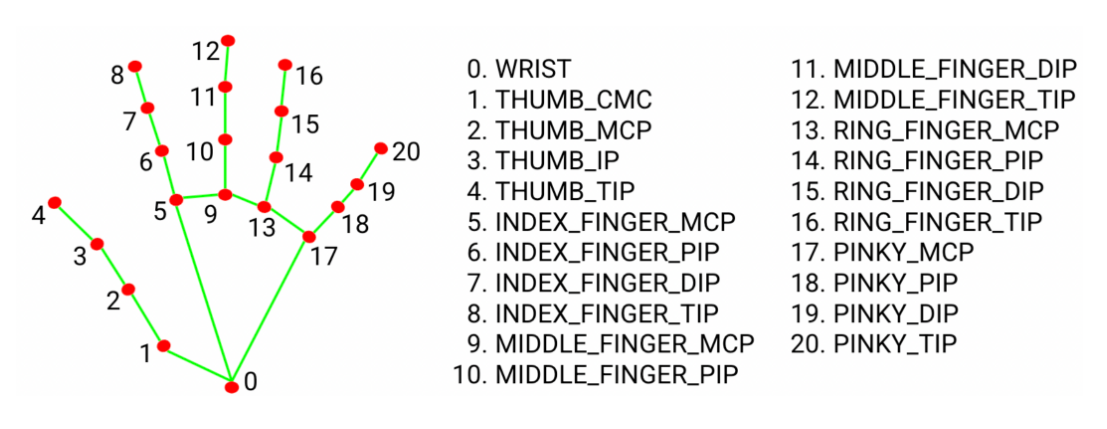

In [3]:
# 10개의 제스처를 매핑 해둔 데이터
gesture = {
    0:'fist', 1:'one', 2:'two', 3:'three', 4:'four', 5:'five',
    6:'six', 7:'rock', 8:'spiderman', 9:'yeah', 10:'ok'
}
# 가위바위보를 위한 제스처만 떼어놓기
rps_gesture = {0:'rock', 5:'paper', 9:'scissors'}

# 손을 찾아주는 모듈
mp_hands = mp.solutions.hands
# 특징점을 연결 관리해주는 모듈 가져오기
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(max_num_hands = 1, # 한손찾기
               min_detection_confidence= 0.5, # 정확하게 손을 찾아주는 역할 (0.5: 신뢰도)
               min_tracking_confidence= 0.5) # 손의 위치 (범위)을 찾아주는 역할

# knn 모델 활용하여 제스처 인식모델 학습
file = np.genfromtxt('./data/gesture_train.csv', delimiter = ',') # 데이터
# 학습용 문제데이터 나눠주기
X_train = file[:,:-1].astype(np.float32)
y_train = file[:, -1].astype(np.float32)
# 모델객체생성
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)

# 캠 초기화
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, img = cap.read()
    if not ret :
        continue

    img = cv2.flip(img,1) # 좌우반전
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    # 관절을 찾을때 도움을 주도록 색상 변경

    result = hands.process(img) # 손정보를 추출해서 담아주기

    # 다시 출력하는 데이터는 우리의 색상으로 변경
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    if result.multi_hand_landmarks is not None: # 손정보를 받아왔다면 진행
        for res in result.multi_hand_landmarks: 
            # 각 관절의 위치를 저장할 비어있는 배열생성하기 (21,3)
            joint = np.zeros((21,3))
            # 관절의 위치정보를 추출하기
            for j,lm in enumerate(res.landmark):
                joint[j] = [lm.x,lm.y,lm.z] # 관절의 위치를 numpy 배열에 저장

            # joint: 점의 위치값 > 통해서 관절값 구하기
            # joint들로 관절값 구하기
            v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19],:] # Parent joint
            v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],:] # Child joint
            v = v2 - v1 # [20,3]
            # Normalize v 유클리디안 길이
            v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

            # 관절값으로 관절 각도 구하기
            angle = np.arccos(np.einsum('nt,nt->n',
                v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:]))

            # radian > degree 각도 값으로 변경해주는 작업이 필요하다!!
            angle = np.degrees(angle)

            # 모델에게 제스처 인식시키기!!
            data = np.array([angle], dtype = np.float32)
            results = knn.predict(data)
            idx = int(results)
            # 제스쳐 인식되면 표시하기
            if idx in rps_gesture.keys():
                cv2.putText(img, text=rps_gesture[idx].upper(), org=(int(res.landmark[0].x * img.shape[1]), int(res.landmark[0].y * img.shape[0] + 20)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

            # 이미지에 각 관절끼리의 연결선 그어주기
            mp_drawing.draw_landmarks(img, res, mp_hands.HAND_CONNECTIONS)

    cv2.imshow('hand', img)
    key = cv2.waitKey(1)
    if key == ord('q'):  # 'q' 키를 눌렀을 때 종료
        cap.release()
        cv2.destroyAllWindows()
        break

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


array([[ 32.647995,  27.334458,  18.777239, ..., 139.415512,  40.519754,
          0.      ],
       [ 45.166793,  26.117019,  18.645196, ..., 128.394781,  23.400235,
          0.      ],
       [ 20.826588,  35.926397,  39.943409, ...,  82.515342,  23.045704,
          0.      ],
       ...,
       [ 38.840654,  10.783952,  14.997242, ...,   2.84796 ,   3.501141,
         10.      ],
       [ 36.957795,  16.89936 ,  21.456777, ...,   4.631371,   3.630589,
         10.      ],
       [ 36.359711,  12.904628,  12.775588, ...,   6.145185,   1.49783 ,
         10.      ]])